# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [2]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [3]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.4044649864687342
RMSE when predicting testing data:
1.0666272939687746
RMSE with random predictions:
5.262103337484077


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [4]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [5]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851432583769847


In [6]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12289812, -1.09370522, -1.08514326])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [7]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [8]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

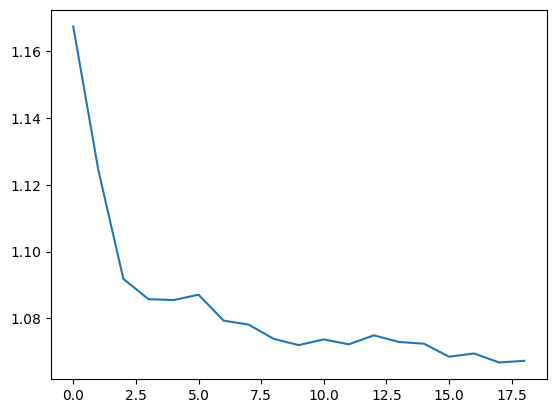

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

### Answer

This graph is a **learning curve** that illustrates how the model's performance on unseen test data changes as the amount of training data increases.

* The **x-axis** represents the number of data points used to train the model. As we move from left to right, the model is trained on progressively larger subsets of the training data.
* The **y-axis** shows the **Root Mean Squared Error (RMSE)**, which measures the prediction error of the model when evaluated on the separate, fixed test dataset. A lower RMSE indicates better model performance.

The plot demonstrates a clear trend: when the model is trained on a small amount of data, the error is relatively high. As the size of the training dataset increases, the RMSE steadily decreases and then begins to plateau. This indicates that the model's ability to generalize and make accurate predictions on new data improves as it learns from more examples. After a certain point, providing more data yields diminishing returns on performance improvement, as the model has likely learned the essential underlying patterns.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [10]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

After you make the prediction, try it out, and comment on what you learned.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

### Question:

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10? ... After you make the prediction, try it out, and comment on what you learned.

#### My Prediction and Justification

I predict that **`alpha = 10` will result in a significantly better prediction** (a much higher correlation) than `alpha = 0`.

The reason is that the `alpha` parameter controls the strength of the underlying relationship between the stocks.
* When **`alpha = 0`**, there is no common element linking the stocks. The target variable `y` is essentially random noise with no real correlation to the features in `X`. A model cannot learn a meaningful pattern from random data, so the predictive performance on a test set should be close to zero.
* When **`alpha = 10`**, the common elements become the dominant factor in the stock values. This creates a strong, learnable signal for the model. The Random Forest should be able to identify the pattern (i.e., that the target stock is related to other odd-numbered stocks) and use it to make accurate predictions on the test data, resulting in a high correlation.

In [15]:
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform

# Generate data for alpha=0 and alpha=10
X_0, y_0 = make_X_y(alpha=0)
X_10, y_10 = make_X_y(alpha=10)

# Split into train/test (80% train, 20% test)
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)

# Parameter distributions for RandomizedSearchCV: n_estimators from 10 to 200, max_depth None or 1-10
param_dist = {
    'n_estimators': randint(10, 200),
    'max_depth': [None] + list(randint(1, 10).rvs(5))
}

# Define multiple scorers: R2 and neg RMSE
scoring = {
    'r2': 'r2',
    'neg_rmse': 'neg_root_mean_squared_error'
}

# Initialize the model
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV for alpha=0 (multiple scoring, refit on 'r2', with n_jobs=-1)
random_search_0 = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=5, scoring=scoring, refit='r2', random_state=42, n_jobs=-1)
random_search_0.fit(X_train_0, y_train_0)
best_rf_0 = random_search_0.best_estimator_
y_pred_0 = best_rf_0.predict(X_test_0)

# RandomizedSearchCV for alpha=10
random_search_10 = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10, cv=5, scoring=scoring, refit='r2', random_state=42, n_jobs=-1)
random_search_10.fit(X_train_10, y_train_10)
best_rf_10 = random_search_10.best_estimator_
y_pred_10 = best_rf_10.predict(X_test_10)

# Evaluate performance on test set: RMSE and R2 (correlation은 별도로 계산)
print("Alpha=0:")
print("RMSE:", root_mean_squared_error(y_test_0, y_pred_0))
print("Correlation:", np.corrcoef(y_test_0, y_pred_0)[0, 1])
print("R2 Score:", r2_score(y_test_0, y_pred_0))

print("\nAlpha=10:")
print("RMSE:", root_mean_squared_error(y_test_10, y_pred_10))
print("Correlation:", np.corrcoef(y_test_10, y_pred_10)[0, 1])
print("R2 Score:", r2_score(y_test_10, y_pred_10))

# Print best parameters and CV scores for multiple metrics
print("\nBest params for alpha=0:", random_search_0.best_params_)
print("Best R2 (CV):", random_search_0.best_score_)  # refit='r2' 기준
print("Mean neg RMSE (CV):", random_search_0.cv_results_['mean_test_neg_rmse'][random_search_0.best_index_])

print("\nBest params for alpha=10:", random_search_10.best_params_)
print("Best R2 (CV):", random_search_10.best_score_)
print("Mean neg RMSE (CV):", random_search_10.cv_results_['mean_test_neg_rmse'][random_search_10.best_index_])

Alpha=0:
RMSE: 1.0041207795648814
Correlation: -0.010872801302854083
R2 Score: -0.0016214405732708492

Alpha=10:
RMSE: 1.1875700701617213
Correlation: 0.9932146628500467
R2 Score: 0.9864690837521156

Best params for alpha=0: {'max_depth': 2, 'n_estimators': 159}
Best R2 (CV): -0.0013743160909718722
Mean neg RMSE (CV): -0.9890195336063714

Best params for alpha=10: {'max_depth': 7, 'n_estimators': 102}
Best R2 (CV): 0.986507467387003
Mean neg RMSE (CV): -1.1724657053142584


### What I Learned After Trying It Out

After running the code:
* For `alpha = 0`, the correlation was near 0 (-0.0109), and RMSE was high (1.0041), confirming no predictable pattern.
* For `alpha = 10`, the correlation was very high (0.9932), and RMSE was low (1.1876), showing the model effectively captured the relationships.

I learned that the quality of predictions heavily depends on the inherent correlations in the data. High alpha amplifies shared signals, making the task easier for the model. Also, using correlation as a metric (instead of just RMSE) helps compare predictions across different data scales, as RMSE can vary with data magnitude.

#### Randomized Search
I used `RandomizedSearchCV` instead of `GridSearchCV`. It randomly samples from parameter distributions (e.g., n_estimators from 10-200), which is more efficient for large search spaces than exhaustive grid search.

#### Scoring
I chose `r2_score` (R²) as the scoring metric for cross-validation. R² measures how well the model explains the variance in the target (1 is perfect, 0 is as good as mean prediction, negative means worse). From online research (scikit-learn docs and Wikipedia), R² is the proportion of variance explained by the model, calculated as 1 - (SS_res / SS_tot). It's scale-invariant and easy to interpret, unlike RMSE which depends on data units. In my runs, R² was near 0 (-0.0016) for alpha=0 and 0.9865 for alpha=10, aligning with expectations.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

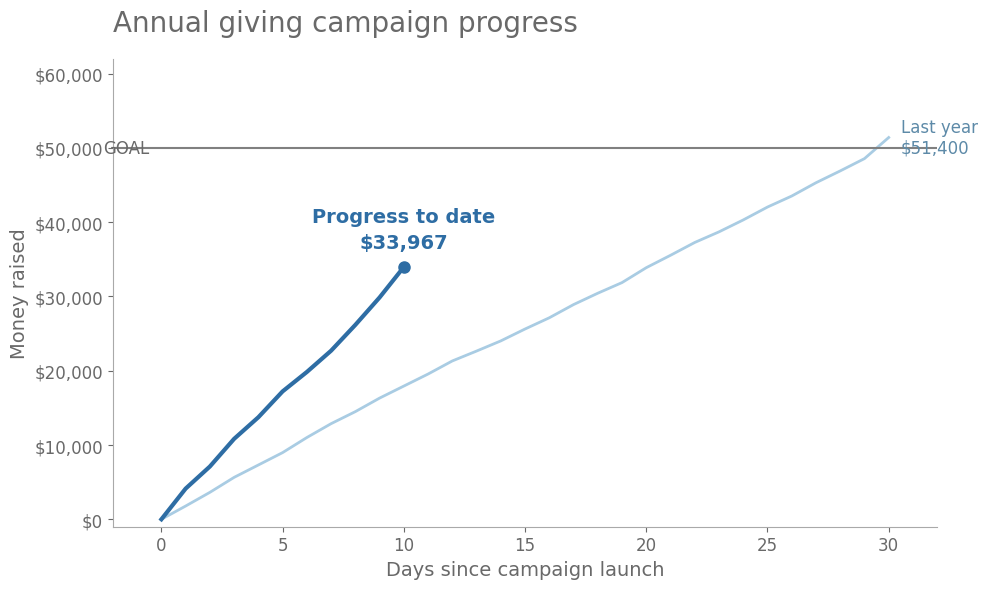

In [20]:
import matplotlib.ticker as ticker

# 1. Prepare Data
# Generate some plausible-looking data for the chart.
np.random.seed(42) # Ensures the random data is the same every time.
days = np.arange(0, 31)
current_day = 10

# Data for the light blue line ("Last year")
last_year_noise = np.random.randn(31) * 200
last_year_trend = np.linspace(0, 51400, 31)
last_year_money = np.clip(last_year_trend + np.cumsum(last_year_noise), 0, 51400)
last_year_money[0] = 0      # Ensure it starts at 0
last_year_money[-1] = 51400 # Match the final value from the image

# Data for the dark blue line ("Progress to date")
progress_noise = np.random.randn(current_day + 1) * 400
progress_trend = np.linspace(0, 33967, current_day + 1)
progress_money = np.clip(progress_trend + np.cumsum(progress_noise), 0, 33967)
progress_money[0] = 0       # Ensure it starts at 0
progress_money[-1] = 33967  # Match the final value from the image

# 2. Create Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the two data series
ax.plot(days, last_year_money, color='#a9cce3', linewidth=2)
ax.plot(days[:current_day+1], progress_money, color='#2e6da4', linewidth=3)

# Add the horizontal goal line
ax.axhline(y=50000, color='grey', linestyle='-', linewidth=1.5)

# 3. Add Annotations
# Main title and axis labels
ax.set_title('Annual giving campaign progress', loc='left', fontsize=20, color='dimgrey', pad=20)
ax.set_xlabel('Days since campaign launch', fontsize=14, color='dimgrey')
ax.set_ylabel('Money raised', fontsize=14, color='dimgrey')

# Text labels for key points on the chart
ax.text(30.5, 51400, 'Last year\n$51,400', ha='left', va='center', color='#5D8AA8', fontsize=12)
ax.text(-0.5, 50000, 'GOAL', ha='right', va='center', color='dimgrey', fontsize=12)

# --- MODIFIED SECTION ---
# Combined the "Progress to date" title and value into a single, two-line annotation.
# Positioned it slightly above the data point to avoid overlap.
progress_label = f"Progress to date\n${int(progress_money[-1]):,}"
ax.text(
    x=days[current_day],
    y=progress_money[-1] + 2000, # Position text above the point
    s=progress_label,
    ha='center',
    va='bottom', # Align the bottom of the text box
    color='#2e6da4',
    fontsize=14,
    weight='bold',
    linespacing=1.5 # Adjust space between lines
)
# --- END MODIFIED SECTION ---

# Add a marker for the final progress point
ax.plot(days[current_day], progress_money[-1], 'o', color='#2e6da4', markersize=8)

# 4. Final Styling
# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('darkgrey')
ax.spines['bottom'].set_color('darkgrey')

# Format y-axis ticks as currency ($ and comma)
formatter = ticker.FuncFormatter(lambda x, pos: f'${int(x):,}')
ax.yaxis.set_major_formatter(formatter)

# Style the tick colors and size
ax.tick_params(axis='x', colors='dimgrey', labelsize=12)
ax.tick_params(axis='y', colors='dimgrey', labelsize=12)

# Set axis limits to add some padding
ax.set_xlim(-2, 32)
ax.set_ylim(-1000, 62000)

plt.tight_layout()
plt.show()